In [28]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import numpy as np
import pandas as pd
from datetime import datetime

import backtrader as bt
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [29]:
import sys

sys.path.append('./Strategies')
sys.path.append('./DataFeeds')

from glove import *
#from buy_and_hold_strats import *
from random_strats import *
from mean_ou_strats import *

In [31]:
import pathlib

# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True)

# Add a strategy
strat = Random
# strat = TestStrategy
# strat = BuyAndHold
# strat = OverUnderMean
cerebro.addstrategy(strat)


data = glove_100k_91_min_feed(dataname = '../Data Preprocessed/glove_100k_91_min.csv', timeframe = bt.TimeFrame.Minutes, compression = 1)
#data = final_dataset_feed(dataname = '../final_dataset3.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)

# cerebro.broker.setcommission(commission=0.001)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

#sizers
cerebro.addsizer(bt.sizers.AllInSizer)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=10)

#observers
cerebro.addobserver(bt.observers.BuySell)

#cerebro.add_order_history(orders, notify=True)

# Set our desired cash start
cerebro.broker.setcash(1)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1.00
SELL EXECUTED,  0.00023929226918465945 BTC AT  4178.99
(CLOSE) BUY EXECUTED,  0.00023929226918465945 BTC AT  3843.34
BUY EXECUTED,  0.00028052933008357073 BTC AT  3850.9999999999995
(CLOSE) SELL EXECUTED,  0.00028052933008357073 BTC AT  3231.7
SELL EXECUTED,  0.0002803740342574356 BTC AT  3233.49
(CLOSE) BUY EXECUTED,  0.0002803740342574356 BTC AT  3688.82
BUY EXECUTED,  0.00021066972659285847 BTC AT  3696.28
(CLOSE) SELL EXECUTED,  0.00021066972659285847 BTC AT  3666.01
BUY EXECUTED,  0.00021073293900400198 BTC AT  3666.0
(CLOSE) SELL EXECUTED,  0.00021073293900400198 BTC AT  3665.0
BUY EXECUTED,  0.00021005777377206884 BTC AT  3667.98
(CLOSE) SELL EXECUTED,  0.00021005777377206884 BTC AT  4102.99
SELL EXECUTED,  0.00021078777650504688 BTC AT  4102.99
(CLOSE) BUY EXECUTED,  0.00021078777650504688 BTC AT  3884.02
SELL EXECUTED,  0.0002342278135278385 BTC AT  3891.83
(CLOSE) BUY EXECUTED,  0.0002342278135278385 BTC AT  3874.98
SELL EXECUTED,  0.00023536864

(CLOSE) BUY EXECUTED,  7.488789660412954e-05 BTC AT  8079.77
SELL EXECUTED,  7.765540805447026e-05 BTC AT  8072.350000000001
(CLOSE) BUY EXECUTED,  7.765540805447026e-05 BTC AT  8228.85
BUY EXECUTED,  7.454330626344032e-05 BTC AT  8228.95
(CLOSE) SELL EXECUTED,  7.454330626344032e-05 BTC AT  8000.009999999999
SELL EXECUTED,  7.460893282788576e-05 BTC AT  8007.89
(CLOSE) BUY EXECUTED,  7.460893282788576e-05 BTC AT  8194.15
SELL EXECUTED,  7.120543948861828e-05 BTC AT  8195.49
(CLOSE) BUY EXECUTED,  7.120543948861828e-05 BTC AT  8700.74
SELL EXECUTED,  6.293907188776347e-05 BTC AT  8719.91
(CLOSE) BUY EXECUTED,  6.293907188776347e-05 BTC AT  9275.79
BUY EXECUTED,  5.517800413048759e-05 BTC AT  9275.79
(CLOSE) SELL EXECUTED,  5.517800413048759e-05 BTC AT  9709.0
SELL EXECUTED,  5.5269806414067205e-05 BTC AT  9709.0
(CLOSE) BUY EXECUTED,  5.5269806414067205e-05 BTC AT  9877.38
BUY EXECUTED,  5.337224376577152e-05 BTC AT  9876.94
(CLOSE) SELL EXECUTED,  5.337224376577152e-05 BTC AT  9820.87

(CLOSE) BUY EXECUTED,  5.595470954235687e-05 BTC AT  9985.4
2018-01-31T00:01:00, Order Canceled/Margin/Rejected
SELL EXECUTED,  6.984984110791875e-05 BTC AT  9912.89
(CLOSE) BUY EXECUTED,  6.984984110791875e-05 BTC AT  10132.99
BUY EXECUTED,  6.702561786087248e-05 BTC AT  10101.21
(CLOSE) SELL EXECUTED,  6.702561786087248e-05 BTC AT  8978.0
SELL EXECUTED,  6.67802313791174e-05 BTC AT  9010.99
(CLOSE) BUY EXECUTED,  6.67802313791174e-05 BTC AT  8849.99
SELL EXECUTED,  6.914122745961368e-05 BTC AT  8861.9
(CLOSE) BUY EXECUTED,  6.914122745961368e-05 BTC AT  9172.55
BUY EXECUTED,  6.464390628039231e-05 BTC AT  9142.84
(CLOSE) SELL EXECUTED,  6.464390628039231e-05 BTC AT  8189.670000000001
BUY EXECUTED,  6.440475761152452e-05 BTC AT  8197.52
(CLOSE) SELL EXECUTED,  6.440475761152452e-05 BTC AT  6915.0
BUY EXECUTED,  6.37242118781468e-05 BTC AT  6929.32
(CLOSE) SELL EXECUTED,  6.37242118781468e-05 BTC AT  7714.7
SELL EXECUTED,  6.424454371418575e-05 BTC AT  7733.88
(CLOSE) BUY EXECUTED,  6.

(CLOSE) SELL EXECUTED,  0.00015214511808931053 BTC AT  6836.0
BUY EXECUTED,  0.00015214511808931053 BTC AT  6836.0
(CLOSE) SELL EXECUTED,  0.00015214511808931053 BTC AT  6935.15
SELL EXECUTED,  0.0001520609217936734 BTC AT  6938.990000000001
(CLOSE) BUY EXECUTED,  0.0001520609217936734 BTC AT  7935.139999999999
BUY EXECUTED,  0.00011363506058184979 BTC AT  7935.14
(CLOSE) SELL EXECUTED,  0.00011363506058184979 BTC AT  7898.31
SELL EXECUTED,  0.00011422657013576365 BTC AT  7898.85
(CLOSE) BUY EXECUTED,  0.00011422657013576365 BTC AT  8002.62
SELL EXECUTED,  0.00011027757861227916 BTC AT  8049.1
(CLOSE) BUY EXECUTED,  0.00011027757861227916 BTC AT  8359.0
BUY EXECUTED,  0.00010220737944070747 BTC AT  8345.5
(CLOSE) SELL EXECUTED,  0.00010220737944070747 BTC AT  8053.36
SELL EXECUTED,  0.0001021741588344452 BTC AT  8060.76
(CLOSE) BUY EXECUTED,  0.0001021741588344452 BTC AT  7878.01
BUY EXECUTED,  0.00010681581781942547 BTC AT  7878.0
(CLOSE) SELL EXECUTED,  0.00010681581781942547 BTC AT 

(CLOSE) BUY EXECUTED,  0.00014461964678955263 BTC AT  6733.92
SELL EXECUTED,  0.00014342823834036843 BTC AT  6739.8
(CLOSE) BUY EXECUTED,  0.00014342823834036843 BTC AT  6760.0
BUY EXECUTED,  0.00014256425370978254 BTC AT  6759.84
(CLOSE) SELL EXECUTED,  0.00014256425370978254 BTC AT  6722.53
BUY EXECUTED,  0.00014265210452081887 BTC AT  6718.39
(CLOSE) SELL EXECUTED,  0.00014265210452081887 BTC AT  6055.17
BUY EXECUTED,  0.00014254734516872789 BTC AT  6056.26
(CLOSE) SELL EXECUTED,  0.00014254734516872789 BTC AT  6177.38
BUY EXECUTED,  0.00014262487950849118 BTC AT  6177.38
(CLOSE) SELL EXECUTED,  0.00014262487950849118 BTC AT  6142.55
SELL EXECUTED,  0.0001426323100282605 BTC AT  6151.76
(CLOSE) BUY EXECUTED,  0.0001426323100282605 BTC AT  6251.22
SELL EXECUTED,  0.00013777918800526114 BTC AT  6255.62
(CLOSE) BUY EXECUTED,  0.00013777918800526114 BTC AT  6070.79
2018-06-27T00:01:00, Order Canceled/Margin/Rejected
BUY EXECUTED,  0.00014648729468129802 BTC AT  6057.59
(CLOSE) SELL EXEC

(CLOSE) BUY EXECUTED,  0.00011457276428232703 BTC AT  7079.46
BUY EXECUTED,  0.00010885998814329692 BTC AT  7074.99
(CLOSE) SELL EXECUTED,  0.00010885998814329692 BTC AT  7030.84
BUY EXECUTED,  0.00010885998814329692 BTC AT  7030.84
(CLOSE) SELL EXECUTED,  0.00010885998814329692 BTC AT  6983.25
SELL EXECUTED,  0.00010909181753106925 BTC AT  6970.650000000001
(CLOSE) BUY EXECUTED,  0.00010909181753106925 BTC AT  7015.22
BUY EXECUTED,  0.00010743708678416247 BTC AT  7015.22
(CLOSE) SELL EXECUTED,  0.00010743708678416247 BTC AT  7185.0
BUY EXECUTED,  0.00010766526910070056 BTC AT  7185.0
(CLOSE) SELL EXECUTED,  0.00010766526910070056 BTC AT  7295.19
BUY EXECUTED,  0.00010762292917442987 BTC AT  7297.01
(CLOSE) SELL EXECUTED,  0.00010762292917442987 BTC AT  7258.54
BUY EXECUTED,  0.00010756410636181146 BTC AT  7260.88
(CLOSE) SELL EXECUTED,  0.00010756410636181146 BTC AT  7357.17
BUY EXECUTED,  0.00010753517647201554 BTC AT  7355.67
(CLOSE) SELL EXECUTED,  0.00010753517647201554 BTC AT  66

(CLOSE) SELL EXECUTED,  0.00011384457845485314 BTC AT  6450.32
BUY EXECUTED,  0.00011387194162999711 BTC AT  6448.78
(CLOSE) SELL EXECUTED,  0.00011387194162999711 BTC AT  6501.0
SELL EXECUTED,  0.00011387194162999711 BTC AT  6501.0
(CLOSE) BUY EXECUTED,  0.00011387194162999711 BTC AT  6405.000000000001
SELL EXECUTED,  0.00011728543308869492 BTC AT  6407.55
(CLOSE) BUY EXECUTED,  0.00011728543308869492 BTC AT  6332.22
BUY EXECUTED,  0.00012016479088824001 BTC AT  6325.05
(CLOSE) SELL EXECUTED,  0.00012016479088824001 BTC AT  6349.39
BUY EXECUTED,  0.00012016479088824001 BTC AT  6349.39
(CLOSE) SELL EXECUTED,  0.00012016479088824001 BTC AT  6372.83
SELL EXECUTED,  0.000120072091931528 BTC AT  6377.75
(CLOSE) BUY EXECUTED,  0.000120072091931528 BTC AT  6324.05
BUY EXECUTED,  0.00012222818228126394 BTC AT  6318.0
(CLOSE) SELL EXECUTED,  0.00012222818228126394 BTC AT  6255.45
SELL EXECUTED,  0.00012224479308850007 BTC AT  6254.6
(CLOSE) BUY EXECUTED,  0.00012224479308850007 BTC AT  5595.99

(CLOSE) SELL EXECUTED,  0.0001666315794998503 BTC AT  3572.97
BUY EXECUTED,  0.00016671973448522602 BTC AT  3572.4999999999995
(CLOSE) SELL EXECUTED,  0.00016671973448522602 BTC AT  3616.28
SELL EXECUTED,  0.0001670509464727407 BTC AT  3616.27
(CLOSE) BUY EXECUTED,  0.0001670509464727407 BTC AT  3640.9899999999993
SELL EXECUTED,  0.00016441301024943766 BTC AT  3641.8999999999996
(CLOSE) BUY EXECUTED,  0.00016441301024943766 BTC AT  3613.68
BUY EXECUTED,  0.0001668788257321617 BTC AT  3615.1
(CLOSE) SELL EXECUTED,  0.0001668788257321617 BTC AT  3676.99
BUY EXECUTED,  0.00016688064074709734 BTC AT  3677.74
(CLOSE) SELL EXECUTED,  0.00016688064074709734 BTC AT  3544.62
SELL EXECUTED,  0.00016715226282050606 BTC AT  3543.76
(CLOSE) BUY EXECUTED,  0.00016715226282050606 BTC AT  3533.7
SELL EXECUTED,  0.00016787220436623103 BTC AT  3533.7
Final Portfolio Value: 0.58


<IPython.core.display.Javascript object>


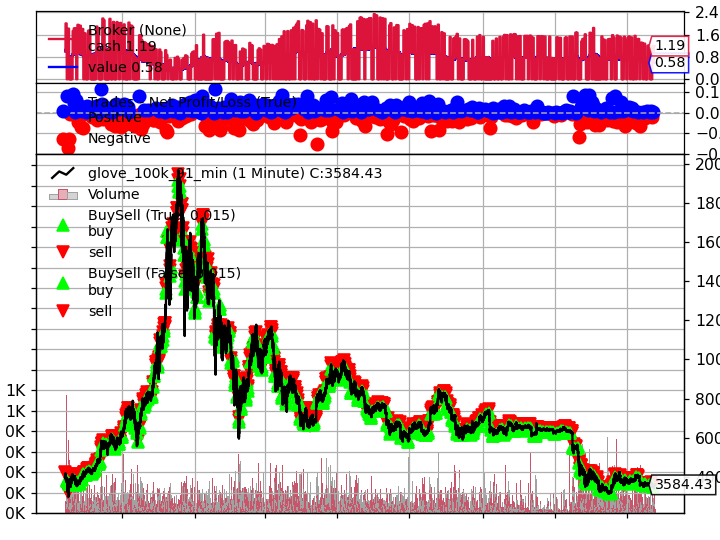

[[<Figure size 640x480 with 4 Axes>]]

In [32]:
cerebro.plot()